In [ ]:
# Importing all the libraries
import pandas as pd
import numpy as np
import html
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
from re import search
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings

**PART 1: DATA CLEANING**

In [ ]:
# Reading the two files 
df_sent = pd.read_csv('/content/sentiment_analysis.csv')
df_elect = pd.read_csv('/content/Canadian_elections_2021.csv')

In [ ]:
# Displaying the generic tweets dataframe
df_sent

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1
...,...,...,...
550386,8.046170e+17,@goddesses_o I can't stop watching her...mm. M...,0
550387,8.046180e+17,Poor old Tom Odell doesn't look like he would ...,0
550388,8.046180e+17,#antsmasher I smashed 7 ants in this awesome ...,1
550389,8.046180e+17,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1


In [ ]:
#Creating a copy of the generic tweet df without the id column
df_sent_cl = df_sent[['text','label']]
#Creating a copy of the election dataset and displaying it
df_elect_cl = df_elect.copy()
df_elect_cl

,text,sentiment,negative_reason
0,The Canadian election is a power grab by PM Tr...,negative,calling election early
1,I do hope Trudeau loses the Canadian election ...,negative,covid
2,"Dear Canadians, This election is a test of how...",positive,NaN
3,Canadian friends: Never forget that Trudeau ha...,negative,calling election early
4,Sorry @theJagmeetSingh I have voted #NDP all m...,positive,NaN
...,...,...,...
997,This is absolutely horrible in Canada. The for...,negative,others
998,@davidakin Trudeau imposes gun control policie...,negative,gun control
999,In Canada 🇨🇦 our election is being stolen by t...,negative,others
1000,"O'Toole amends platform on gun control, but qu...",negative,tell lies


In [ ]:
# 1 Using a regex, compile the regex pattern and match them into original text
def remove_html(text):
    html_remove = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(html_remove, '', text)
    return cleantext

# 2 Convert html character codes to ascii equivalent
def ascii_equiv(text):
    ascii_equiv = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    return ascii_equiv

# 3 Remove patterns from the text
def remove_pattern(text, pattern):
    r = re.findall(pattern, text)
    for i in r:
        text = re.sub(i, '', text)
        
    return text


# 4 Make all character lower case first
def lowercase(text):
    text = text.lower()
    return text

# 5 Remove all urls
def remove_URL(text):
    rem_url = re.sub('http\S+', '', text)
    return rem_url

# 6 Loading stopwords(English) from NLTK package
from nltk.tokenize import wordpunct_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words  = stopwords.words("english")
# Printing the number of stopwords in the package
print(len(stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
179


In [ ]:
warnings.filterwarnings("ignore")
# Remove html for generic tweets
df_sent_cl['text'] = df_sent_cl['text'].apply(remove_html)
# Convert html to ascii equivalent for generic tweets
df_sent_cl['text'] = df_sent_cl['text'].apply(ascii_equiv)
# Remove URLs for generic tweets
df_sent_cl['text'] = df_sent_cl['text'].apply(remove_URL)
# Convert every word to lowercase for generic tweets
df_sent_cl['text'] = df_sent_cl['text'].apply(lowercase)

In [ ]:
warnings.filterwarnings("ignore")
# Remove html for election tweets
df_elect_cl['text'] = df_elect_cl['text'].apply(remove_html)
# Convert html to ascii equivalent election tweets
df_elect_cl['text'] = df_elect_cl['text'].apply(ascii_equiv)
# Remove URLs election tweets
df_elect_cl['text'] = df_elect_cl['text'].apply(remove_URL)
# Convert every word to lowercase election tweets
df_elect_cl['text'] = df_elect_cl['text'].apply(lowercase)

In [ ]:
!pip install tqdm
from tqdm import tqdm
nltk.download('punkt')
# Tokenizing the tweets of the generic tweets dataset to remove stopwords
# tqdm lib. shows the progress
tqdm.pandas(desc="Tokenizing...")
df_sent_cl['text'] = df_sent_cl['text'].progress_apply(nltk.tokenize.word_tokenize)
df_sent_cl['text'].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Tokenizing...: 100%|██████████| 550391/550391 [01:50<00:00, 4974.80it/s]


0    [josh, jenkins, is, looking, forward, to, tab,...
1    [rt, @, mianusmanjaved, :, congratulations, pa...
2    [rt, @, pepalerts, :, this, september, ,, @, y...
3    [rt, @, david_gaibis, :, newly, painted, walls...
4    [rt, @, cedricfeschotte, :, excited, to, annou...
Name: text, dtype: object

In [ ]:
# Removing all the stopwords for the generic tweets
df_sent_cl['text'] = df_sent_cl['text'].apply(lambda x: [item for item in x if item not in stop_words])

In [ ]:
# Tokenize tweets of the election tweets dataset to remove stopwords
tqdm.pandas(desc="Tokenizing...")
df_elect_cl['text'] = df_elect_cl['text'].progress_apply(nltk.tokenize.word_tokenize)
df_elect_cl['text'].head()

Tokenizing...: 100%|██████████| 1002/1002 [00:00<00:00, 2687.10it/s]


0    [the, canadian, election, is, a, power, grab, ...
1    [i, do, hope, trudeau, loses, the, canadian, e...
2    [dear, canadians, ,, this, election, is, a, te...
3    [canadian, friends, :, never, forget, that, tr...
4    [sorry, @, thejagmeetsingh, i, have, voted, #,...
Name: text, dtype: object

In [ ]:
# Removing all the stopwords for the election dataset
df_elect_cl['text'] = df_elect_cl['text'].apply(lambda x: [item for item in x if item not in stop_words])

In [ ]:
# After removing stopwords from all tweets, join tokenized tweets for further analysis
# Join tokenized texts for both the generic tweets and the election datasets
def join(tweet):
    tweet = " ".join(tweet)
    return tweet

df_sent_cl['text']  = df_sent_cl['text'].apply(join)
df_elect_cl['text']  = df_elect_cl['text'].apply(join)

**PART 2: EXPLORATORY ANALYSIS**

In [ ]:
# Keyword for segregating the four Parties 
liberal = ['justin','climatechange','healthcarematters','otoolethefool', 'trudeau','nevervotecpc','nevervoteconservative', 'liberal','liberalmajority',
           'dontvoteconservative','justintrudeau', 'forwardforeveryone','votered','pm','istandwithtrudeau','voteliberalmajority','voteliberal','hillary',
           'hillaryclinton']
conservative = ['Secure the Future','otooleforpm','hope','erinotoole','tooearlyelxn','votetrudeauout','trudeaumustgo','cpc','conservative', 'erin','votecpc',
                'toole',"erin o'toole", 'voteblue','gun control','gun','calling election early','voteconservative','conservatives']
ndp = ['Fighting for You','ndp','basicincome','jagmeet singh','thejagmeetsingh','singh','jagmeet','voteorange','singh','jagmeetsingh','ndp2021','votendp',
       'bernie','teamjagmeet','readyforbetter']
ppc = ['maxime bernier','maximebernier','handsoffmyguns','maxime','voteppc2021','voteppcforfiscalresponsibility','bernier','ppc','ppc-peoples','votepurple',
       'purplereign','freedom','voteppc','unitedweroll','canadafirst','maximebernier']
# Creating a column called party
df_elect_cl['party'] = 'NaN'
# Creating a dataframe for each of the parties
liberal_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])
conserv_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])
ndp_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])
ppc_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])
# This is for tweets that don't belong to one specific party/ hard to clasify tweets
others_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])

for i in range(df_elect_cl.shape[0]):
    liberal_list = []
    conservative_list = []
    ndp_list = []
    ppc_list = []
    elec_tweet_list = df_elect_cl['text'][i].split()

    for l in liberal:
        for t in elec_tweet_list:
            if l in t:
                liberal_list.append(t)
    for c in conservative:
        for t in elec_tweet_list:
             if c in t:
                conservative_list.append(t)
    for n in ndp:
        for t in elec_tweet_list:
            if n in t:
                ndp_list.append(t)
    for p in ppc:
        for t in elec_tweet_list:
             if p in t:
                ppc_list.append(t)

# If there are 2 or more keywords from any one particular party, then that tweet will be classified as that particular party else it will be classified as others             
    if len(liberal_list) >= 2:
        liberal_df = liberal_df.append(df_elect_cl.iloc[i], ignore_index=True)
        df_elect_cl['party'][i] = 'Liberal'
    elif len(conservative_list) >= 2:
        conserv_df = conserv_df.append(df_elect_cl.iloc[i], ignore_index=True)
        df_elect_cl['party'][i] = 'Conservative'
    elif len(ndp_list) >= 1:
        ndp_df = ndp_df.append(df_elect_cl.iloc[i], ignore_index=True)
        df_elect_cl['party'][i] = 'NDP'
    elif len(ppc_list) >= 1:
        ppc_df = ppc_df.append(df_elect_cl.iloc[i], ignore_index=True)
        df_elect_cl['party'][i] = 'PPC'
    else:
      others_df = others_df.append(df_elect_cl.iloc[i], ignore_index=True)
      df_elect_cl['party'][i] = 'Others'


In [ ]:
# Printing the percentage of tweets for each of the parties
print('The Liberal Party has',(liberal_df.shape[0]/df_elect_cl.shape[0])*100,'% tweets')
print('The Conservative Party has',(conserv_df.shape[0]/df_elect_cl.shape[0])*100,'% tweets')
print('The NDP Party has',(ndp_df.shape[0]/df_elect_cl.shape[0])*100,'% tweets')
print('The PPC Party has',(ppc_df.shape[0]/df_elect_cl.shape[0])*100,'% tweets')
print('Others has',(others_df.shape[0]/df_elect_cl.shape[0])*100,'% tweets')


The Liberal Party has 26.746506986027946 % tweets
The Conservative Party has 17.065868263473057 % tweets
The NDP Party has 5.9880239520958085 % tweets
The PPC Party has 5.9880239520958085 % tweets
Others has 44.21157684630739 % tweets


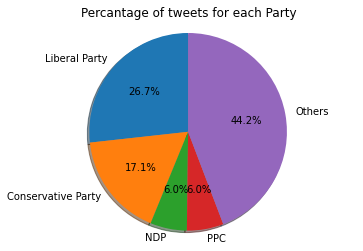

In [ ]:
# Plotting a pie chart for each of the 4 parties
labels = 'Liberal Party', 'Conservative Party','NDP','PPC', 'Others'
sizes = [liberal_df.shape[0]/df_elect_cl.shape[0], conserv_df.shape[0]/df_elect_cl.shape[0],ndp_df.shape[0]/df_elect_cl.shape[0],ppc_df.shape[0]/df_elect_cl.shape[0], 
         others_df.shape[0]/df_elect_cl.shape[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.title('Percantage of tweets for each Party')
plt.show()

It can be seen that 26.7% of the tweets are talking about the liberal party, 17.1% are talking about the conservative, and only 6% are talking about NDP and PPC parties. Almost half, 44.2%, are labeled as others because they are ambiguous.

From this, it can be inferred that the most popular parties in Canada are the liberal and the conservatives, and they are most likely to win the election as well.

In [ ]:
# Classifying the number of positive and negative tweets for the generic tweet dataset
pos_tw_df = df_sent.loc[df_sent['label'] == 1]
neg_tw_df = df_sent.loc[df_sent['label'] == 0]
pos_tw_count = pos_tw_df.shape[0]
neg_tw_count = neg_tw_df.shape[0]

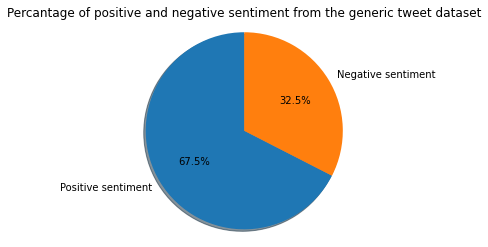

In [ ]:
# Plotting a pie chart for the positive and negative tweets in the generic tweet dataset
labels = ['Positive sentiment', 'Negative sentiment']
sizes = [pos_tw_count, neg_tw_count]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percantage of positive and negative sentiment from the generic tweet dataset')
plt.show()

From the above pie chart for the generic tweet dataset, it can be seen that 67.5% are positive tweets, and it outnumbers the negative tweets, which are only 32.5%. Therefore, we are working with an imbalanced dataset. This could affect the model's performance when trained on this dataset, as the model could end up predicting most of the tweets as positive.

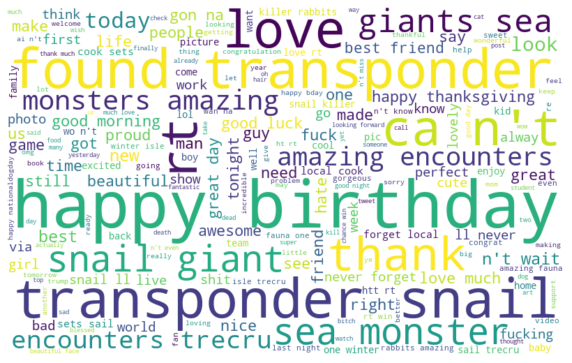

In [ ]:
# Plotting the wordcload for all the generic tweets to see the most commonly used words
def plot_wordCloud(words):
    wordcloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=110).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    
all_words = ' '.join([text for text in df_sent_cl['text']])
plot_wordCloud(all_words) 

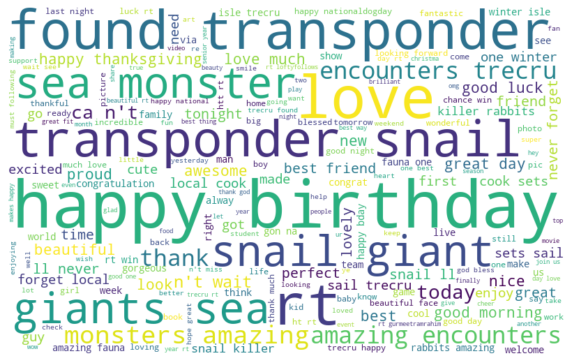

In [ ]:
# Plotting a wordcloud for only the Positive tweets to see the most commonly used words in generic tweets dataset
positive_words = ' '.join([text for text in df_sent_cl['text'][df_sent_cl['label'] == 1]])
plot_wordCloud(positive_words)

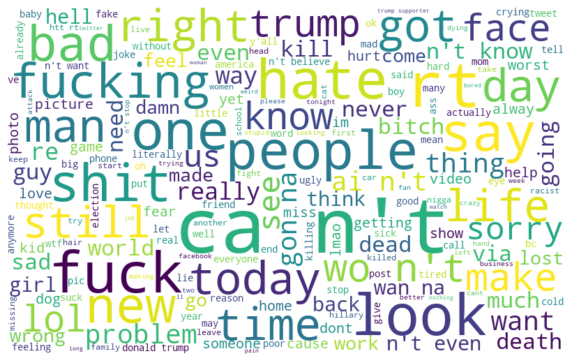

In [ ]:
 # Plotting a wordcloud for only the Negative tweets to see the most commonly used words in generic tweets dataset
Negative tweets
negative_tweets =' '.join([text for text in df_sent_cl['text'][df_sent_cl['label'] == 0]])
plot_wordCloud(negative_tweets)

In [ ]:
# Function for getting the hashtag from the tweets 
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"# (\w+)", i)
        hashtags.append(ht)

    return hashtags


In [ ]:
# extracting hashtags from the negative election tweets 
neg_ht = hashtag_extract(df_elect_cl['text'][df_elect_cl['sentiment'] == 'negative'])

# extracting hashtags from the positive election tweets
pos_ht = hashtag_extract(df_elect_cl['text'][df_elect_cl['sentiment'] == 'positive'])

# unnesting list
neg_ht1 = sum(neg_ht,[])
pos_ht1 = sum(pos_ht,[])

[Text(0.5, 1.0, 'Negative Tweets from the 2021 elections')]

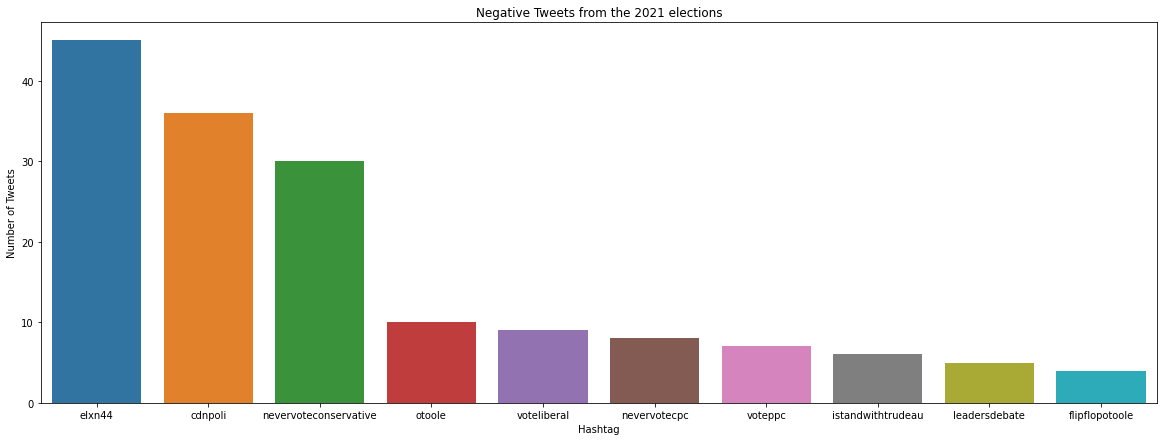

In [ ]:
# Plotting graph for the negative hashtags in the election dataset
a = nltk.FreqDist(neg_ht1)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(20,7))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Number of Tweets')
ax.set(title = 'Negative Tweets from the 2021 elections')

The above bar chart shows that most of the negative tweets are associated with the conservative party and its leader. The first two bars, elxn44, and cdnpoli can be ignored as they are general hashtags for the Canadian elections; hence they appear the most.

[Text(0.5, 1.0, 'Positive Tweets from the 2021 elections')]

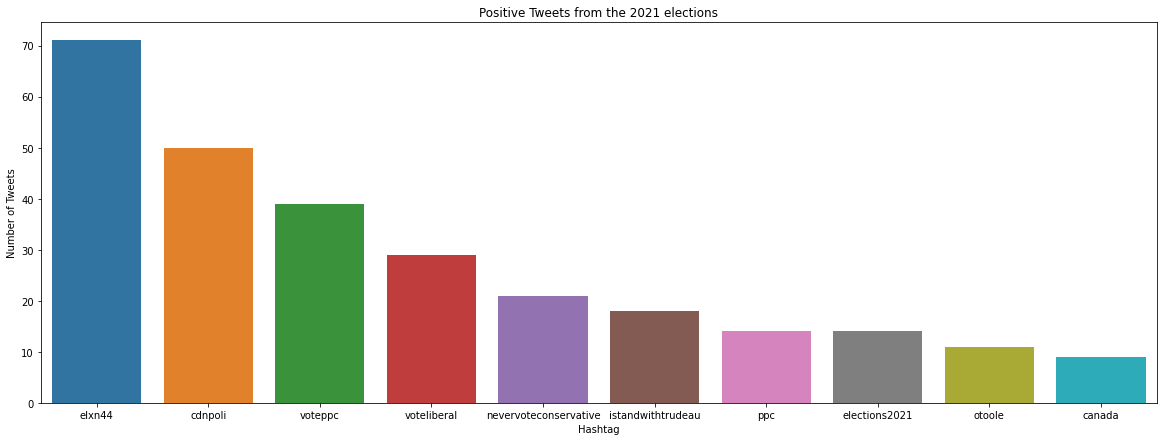

In [ ]:
# Plotting graph for the positive hashtags from the election dataset
a = nltk.FreqDist(pos_ht1)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(20,7))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Number of Tweets')
ax.set(title = 'Positive Tweets from the 2021 elections')

For the positive bar chart, we can see that most of the tweets favor the PPC party followed by the liberal party. Again elxn44 and cdnpoli can be ignored.

**PART 3: MODEL PREPARATION**

In [ ]:
# Spliting the generic tweet dataset into features and labels
x = df_sent_cl['text']
y = df_sent_cl['label']

In [ ]:
# Splitting the dataset into training and testing set (70% training and 30% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)


In [ ]:
# Applying Bag of Words on the generic tweet dataset
vector = CountVectorizer()
bow_x_train = vector.fit_transform(x_train)
bow_x_test = vector.transform(x_test)

In [ ]:
# Applying TF-IDF on the generic tweet dataset
tfvector = TfidfVectorizer()
tf_x_train = tfvector.fit_transform(x_train)
tf_x_test = tfvector.transform(x_test)


In [ ]:
bow_x_train, tf_x_train

(<385273x282562 sparse matrix of type '<class 'numpy.int64'>'
 	with 2913133 stored elements in Compressed Sparse Row format>,
 <385273x282562 sparse matrix of type '<class 'numpy.float64'>'
 	with 2913133 stored elements in Compressed Sparse Row format>)

I have kept it in the sparse matrix as converting it into a dense matrix or array would crash the system due to memory limitations. I tried to lower the total number of features to around 2000; although the system didn't crash, the results didn't improve. So, I decided to keep it in the sparse matrix and use all the features. As the sparse matrix is composed of many zeroes. 

1) It compresses the memory footprint of our matrix object to save a lot of memory.  

2) Any algorithm that applies basic mathematical computation like multiplication can benefit from a sparse matrix implementation as it operates only on elements that will return nonzero values resulting in faster computation times.

**PART 4: MODEL IMPLEMENTATION AND TUNNING**

**1) LOGISTIC REGRESSION**  

a) Using Bag of Words

In [ ]:
# for hyperparameter tuning passing 5 values of C and choosing the one that gives the best result
c_values = np.logspace(-3,4,5)
f1_scores = []
for c in c_values: 
  print(c)
  lr_bow = LogisticRegression(C=c)
  lr_bow.fit(bow_x_train, y_train)
  pred_bow = lr_bow.predict(bow_x_test)
  f1 = f1_score(y_test,pred_bow)
  f1_scores.append(f1)

best_c_value = c_values[f1_scores.index(max(f1_scores))]
print('The best F1 Score is:',max(f1_scores), 'for C value:', best_c_value)

0.001
0.05623413251903491
3.1622776601683795
177.82794100389228
10000.0
The best F1 Score is: 0.9816370657064897 for C value: 3.1622776601683795


In [ ]:
# Doing Logistic Regression using the best C value obtained using F1 Score and reporting all the metrics
lr_bow = LogisticRegression(C=best_c_value)
lr_bow.fit(bow_x_train, y_train)
pred_bow = lr_bow.predict(bow_x_test)
print(classification_report(y_test, pred_bow))
print('The accuracy is', accuracy_score(y_test,pred_bow))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     53707
           1       0.98      0.98      0.98    111411

    accuracy                           0.98    165118
   macro avg       0.97      0.97      0.97    165118
weighted avg       0.98      0.98      0.98    165118

The accuracy is 0.9752601170072311


b) Using TF-IDF 

In [ ]:
# for hyperparameter tuning passing 5 values of C and choosing the one that gives the best result
c_values = np.logspace(-4,4,10)
f1_scores = []

for c in c_values: 
  lr_tf = LogisticRegression(C=c)
  lr_tf.fit(tf_x_train, y_train)
  pred_tf = lr_tf.predict(tf_x_test)
  f1 = f1_score(y_test,pred_tf)
  f1_scores.append(f1)

best_c_value = c_values[f1_scores.index(max(f1_scores))]
print('The best F1 Score is:',max(f1_scores), 'for C value:', best_c_value)

The best F1 Score is: 0.981203024388055 for C value: 2.782559402207126


In [ ]:
# Doing Logistic Regression using the best C value obtained using F1 Score and reporting all the metrics
lr_tf = LogisticRegression(C=best_c_value)
lr_tf.fit(tf_x_train, y_train)
pred_tf = lr_tf.predict(tf_x_test)
print(classification_report(y_test, pred_tf))
print('The accuracy is', accuracy_score(y_test,pred_tf))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     53707
           1       0.98      0.98      0.98    111411

    accuracy                           0.97    165118
   macro avg       0.97      0.97      0.97    165118
weighted avg       0.97      0.97      0.97    165118

The accuracy is 0.9746302644169624


**2) K-NN**

a) Using Bag of Words

In [ ]:
# for hyperparameter tuning passing 3 values of 'k' and choosing the one that gives the best result
k_values = [5,10,15]
f1_scores_knn = []

for k in k_values:
  print(k)
  knn_bow = KNeighborsClassifier(n_neighbors=k)
  knn_bow = knn_bow.fit(bow_x_train, y_train)
  pred_bow_knn = knn_bow.predict(bow_x_test)
  f1 = f1_score(y_test,pred_bow_knn)
  f1_scores_knn.append(f1)

best_k_value = k_values[f1_scores_knn.index(max(f1_scores_knn))]
print('The best F1 Score is:',max(f1_scores_knn), 'for k value:', best_k_value)

5
10
15
The best F1 Score is: 0.9200132444066034 for k value: 5


In [ ]:
# The Best KNN MODEL using BOW and the best 'k' value
knn_bow = KNeighborsClassifier(n_neighbors=best_k_value)
knn_bow = knn_bow.fit(bow_x_train, y_train)
pred_bow_knn = knn_bow.predict(bow_x_test)
print(classification_report(y_test,pred_bow_knn))

              precision    recall  f1-score   support

           0       0.78      0.95      0.86     53707
           1       0.97      0.87      0.92    111411

    accuracy                           0.90    165118
   macro avg       0.88      0.91      0.89    165118
weighted avg       0.91      0.90      0.90    165118



b) Using TF-IDF

In [ ]:
# The Best KNN MODEL using TF-IDF and the same 'best k value' as before
knn_tf = KNeighborsClassifier(n_neighbors=best_k_value)
knn_tf = knn_tf.fit(tf_x_train, y_train)
pred_tf_knn = knn_tf.predict(tf_x_test)
print(classification_report(y_test,pred_tf_knn))

              precision    recall  f1-score   support

           0       0.44      0.97      0.60     53707
           1       0.96      0.40      0.57    111411

    accuracy                           0.58    165118
   macro avg       0.70      0.68      0.58    165118
weighted avg       0.79      0.58      0.58    165118



**3) NAIVE BAYES:**

a) Using Bag of Words

In [ ]:
"""" MultinomialNB implements the naive Bayes algorithm for multinomially distributed data.
  It is one of the two classic naive Bayes variants that is commonly used in text classification"""
# For hyperparameter tunning passed 10 alpha values from 0-1 
alpha_values = np.arange(0,1,0.1)
f1_scores_nb = []
for a in alpha_values:
  nb_bow = MultinomialNB(alpha=a)
  nb_bow = nb_bow.fit(bow_x_train, y_train)
  pred_nb_bow = nb_bow.predict(bow_x_test)
  f1 = f1_score(y_test,pred_nb_bow)
  f1_scores_nb.append(f1)

best_a_value = alpha_values[f1_scores_nb.index(max(f1_scores_nb))]
print('The best F1 Score is:',max(f1_scores_nb), 'for alpha value:', best_a_value)

The best F1 Score is: 0.9628702173070325 for alpha value: 0.9


In [ ]:
# Prininting the F1 score and other metrics for the best alpha value
nb_bow = MultinomialNB(alpha=best_a_value)
nb_bow = nb_bow.fit(bow_x_train, y_train)
pred_nb_bow = nb_bow.predict(bow_x_test)
print(classification_report(y_test,pred_nb_bow))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     53707
           1       0.96      0.97      0.96    111411

    accuracy                           0.95    165118
   macro avg       0.95      0.94      0.94    165118
weighted avg       0.95      0.95      0.95    165118



b) Using TF-IDF

In [ ]:
# For hyperparameter tunning passed 10 alpha values from 0-1 
alpha_values = np.arange(0,1,0.1)
f1_scores_nb = []
for a in alpha_values:
  nb_tf = MultinomialNB(alpha=a)
  nb_tf = nb_tf.fit(tf_x_train, y_train)
  pred_nb_tf = nb_tf.predict(tf_x_test)
  f1 = f1_score(y_test,pred_nb_tf)
  f1_scores_nb.append(f1)

best_a_value = alpha_values[f1_scores_nb.index(max(f1_scores_nb))]
print('The best F1 Score is:',max(f1_scores_nb), 'for alpha value:', best_a_value)

The best F1 Score is: 0.9469169229690773 for alpha value: 0.30000000000000004


In [ ]:
# Prininting the F1 score and other metrics for the best alpha value
nb_tf = MultinomialNB(alpha=best_a_value)
nb_tf = nb_tf.fit(tf_x_train, y_train)
pred_nb_tf = nb_tf.predict(tf_x_test)
print(classification_report(y_test,pred_nb_tf))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88     53707
           1       0.92      0.97      0.95    111411

    accuracy                           0.93    165118
   macro avg       0.93      0.90      0.91    165118
weighted avg       0.93      0.93      0.93    165118



**4) SVM:**

a) Using Bag of Words

In [ ]:
"""linearSVC is similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, 
 so it has more flexibility in the choice of penalties and loss functions and should scale better to a large dataset.
  Since our dataset has a lot of features, linearSVC is used"""

# For hyperparameter tunning 5 C values are passed and the best one is chosen based on the F1 score 
svm_c = np.arange(0.1,1,0.2)
f1_scores_svm = []
for c in svm_c:
  print(c)
  svm_bow = LinearSVC(C=c)
  svm_bow.fit(bow_x_train, y_train)
  pred_svm_bow = svm_bow.predict(bow_x_test)
  f1 = f1_score(y_test,pred_svm_bow)
  f1_scores_svm.append(f1)

best_c_value = svm_c[f1_scores_svm.index(max(f1_scores_svm))]
print('The best F1 Score is:',max(f1_scores_svm), 'for c value:', best_c_value)

0.1
0.30000000000000004
0.5000000000000001
0.7000000000000001
0.9000000000000001
The best F1 Score is: 0.981499215458833 for c value: 0.1


In [ ]:
# The F1 score and other metrics are calculated using the best c-value
svm_bow = LinearSVC(C=best_c_value)
svm_bow.fit(bow_x_train, y_train)
pred_svm_bow = svm_bow.predict(bow_x_test)
print(classification_report(y_test, pred_svm_bow))
print('The accuracy is', accuracy_score(y_test,pred_svm_bow))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     53707
           1       0.98      0.98      0.98    111411

    accuracy                           0.98    165118
   macro avg       0.97      0.97      0.97    165118
weighted avg       0.98      0.98      0.98    165118

The accuracy is 0.9750784287600383


b) Using TF-IDF

In [ ]:
# For hyperparameter tunning 5 C values are passed and the best one is chosen based on the F1 score 
svm_c = np.arange(0.1,1,0.2)
f1_scores_svm = []
for c in svm_c:
  print(c)
  svm_tf = LinearSVC(C=c)
  svm_tf.fit(tf_x_train, y_train)
  pred_svm_tf = svm_tf.predict(tf_x_test)
  f1 = f1_score(y_test,pred_svm_tf)
  f1_scores_svm.append(f1)

best_c_value = svm_c[f1_scores_svm.index(max(f1_scores_svm))]
print('The best F1 Score is:',max(f1_scores_svm), 'for c value:', best_c_value)

0.1
0.30000000000000004
0.5000000000000001
0.7000000000000001
0.9000000000000001
The best F1 Score is: 0.981888530300242 for c value: 0.30000000000000004


In [ ]:
# The F1 score and other metrics are calculated using the best c-value
svm_tf = LinearSVC(C=best_c_value)
svm_tf.fit(tf_x_train, y_train)
pred_svm_tf = svm_tf.predict(tf_x_test)
print(classification_report(y_test, pred_svm_tf))
print('The accuracy is', accuracy_score(y_test,pred_svm_tf))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96     53707
           1       0.98      0.98      0.98    111411

    accuracy                           0.98    165118
   macro avg       0.97      0.97      0.97    165118
weighted avg       0.98      0.98      0.98    165118

The accuracy is 0.9755629307525527


**5) DECISION TREE:**

a) Using Bag of Words

In [ ]:
# Used the default values to speed up computation time
dt_bow = DecisionTreeClassifier()
dt_bow = dt_bow.fit(bow_x_train, y_train)
pred_bow_dt = dt_bow.predict(bow_x_test)
print(classification_report(y_test, pred_bow_dt))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     53707
           1       0.96      0.96      0.96    111411

    accuracy                           0.95    165118
   macro avg       0.94      0.95      0.94    165118
weighted avg       0.95      0.95      0.95    165118



b) Using TF-IDF

In [ ]:
# Used the default values to speed up computation time
dt_tf = DecisionTreeClassifier()
dt_tf = dt_tf.fit(tf_x_train, y_train)
pred_tf_dt = dt_tf.predict(tf_x_test)
print(classification_report(y_test, pred_tf_dt))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     53707
           1       0.96      0.96      0.96    111411

    accuracy                           0.95    165118
   macro avg       0.94      0.94      0.94    165118
weighted avg       0.95      0.95      0.95    165118



**6) RANDOM FOREST:**

a) Using Bag of Words

In [ ]:
# Bag of word 
# For hyperparameter tunning 2-n estimators were used to chose the best one
est_values = np.arange(10,30,10)
f1_scores_rf = []
for n in est_values:
  print(n)
  rf_bow = RandomForestClassifier(n_estimators=n)
  rf_bow = rf_bow.fit(bow_x_train, y_train)
  pred_rf_bow = rf_bow.predict(bow_x_test)
  f1 = f1_score(y_test, pred_rf_bow)
  f1_scores_rf.append(f1)

best_n_value = est_values[f1_scores_rf.index(max(f1_scores_rf))]
print('The best F1 Score is:',max(f1_scores_rf), 'for the n-estimator:', best_n_value)

10
20
The best F1 Score is: 0.968576192003759 for the n-estimator: 20


In [ ]:
# The best n-value is used and the F1 and other metrics are calculated
rf_bow = RandomForestClassifier(n_estimators=best_n_value)
rf_bow = rf_bow.fit(bow_x_train, y_train)
pred_rf_bow = rf_bow.predict(bow_x_test)
print(classification_report(y_test, pred_rf_bow))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     53707
           1       0.98      0.96      0.97    111411

    accuracy                           0.96    165118
   macro avg       0.95      0.96      0.95    165118
weighted avg       0.96      0.96      0.96    165118



b) TF-IDF

In [ ]:
# For hyperparameter tunning 2-n estimators were used to chose the best one
est_values = np.arange(10,30,10)
f1_scores_rf = []
for n in est_values:
  print(n)
  rf_tf = RandomForestClassifier(n_estimators=n)
  rf_tf = rf_tf.fit(tf_x_train, y_train)
  pred_rf_tf = rf_tf.predict(tf_x_test)
  f1 = f1_score(y_test, pred_rf_tf)
  f1_scores_rf.append(f1)

best_n_value = est_values[f1_scores_rf.index(max(f1_scores_rf))]
print('The best F1 Score is:',max(f1_scores_rf), 'for the n-estimator:', best_n_value)

10
20
The best F1 Score is: 0.9691689008042895 for the n-estimator: 20


In [ ]:
# The best n-value is used and the F1 and other metrics are calculated
rf_tf = RandomForestClassifier(n_estimators=best_n_value)
rf_tf = rf_tf.fit(tf_x_train, y_train)
pred_rf_tf = rf_tf.predict(tf_x_test)
print(classification_report(y_test, pred_rf_tf))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     53707
           1       0.97      0.97      0.97    111411

    accuracy                           0.96    165118
   macro avg       0.95      0.95      0.95    165118
weighted avg       0.96      0.96      0.96    165118



**7) XGBOOST:**

a) Using Bag of Words

In [ ]:
# For hyperparameter tunning 3 different learning rate were used 
lr = [0.1,0.01,0.05]
f1_scores_xg = []
for l in lr:
  print(l)
  xg_bow = xgb.XGBClassifier(learning_rate=l)
  xg_bow = xg_bow.fit(bow_x_train, y_train)
  pred_xg_bow = xg_bow.predict(bow_x_test)
  f1 = f1_score(y_test, pred_xg_bow)
  f1_scores_xg.append(f1)


best_lr_value = lr[f1_scores_xg.index(max(f1_scores_xg))]
print('The best F1 Score is:',max(f1_scores_xg), 'for the learning rate:', best_lr_value)

0.1
0.01
0.05
The best F1 Score is: 0.8894641519453056 for the learning rate: 0.1


In [ ]:
# The best lr is used to calculate the f1 score and other metrics  
xg_bow = xgb.XGBClassifier(learning_rate=best_lr_value)
xg_bow = xg_bow.fit(bow_x_train, y_train)
pred_xg_bow = xg_bow.predict(bow_x_test)
print(classification_report(y_test, pred_xg_bow))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80     53707
           1       0.94      0.84      0.89    111411

    accuracy                           0.86    165118
   macro avg       0.84      0.87      0.85    165118
weighted avg       0.87      0.86      0.86    165118



b) Using TF-IDF

In [ ]:
# For hyperparameter tunning 3 different learning rate were used 
lr = [0.1,0.01,0.05]
f1_scores_xg = []
for l in lr:
  print(l)
  xg_tf = xgb.XGBClassifier(learning_rate=l)
  xg_tf = xg_tf.fit(tf_x_train, y_train)
  pred_xg_tf = xg_tf.predict(tf_x_test)
  f1 = f1_score(y_test, pred_xg_tf)
  f1_scores_xg.append(f1)


best_lr_value = lr[f1_scores_xg.index(max(f1_scores_xg))]
print('The best F1 Score is:',max(f1_scores_xg), 'for the learning rate:', best_lr_value)

0.1
0.01
0.05
The best F1 Score is: 0.8884490261723578 for the learning rate: 0.1


In [ ]:
# The best lr is used to calculate the f1 score and other metrics  
xg_tf = xgb.XGBClassifier(learning_rate=best_lr_value)
xg_tf = xg_tf.fit(tf_x_train, y_train)
pred_xg_tf = xg_tf.predict(tf_x_test)
print(classification_report(y_test, pred_xg_tf))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80     53707
           1       0.94      0.84      0.89    111411

    accuracy                           0.86    165118
   macro avg       0.84      0.87      0.85    165118
weighted avg       0.87      0.86      0.86    165118



In [ ]:
# Displaying the results from all model in a Dataframe format
results = {
    'Logistic Regression': [97.53,97.46],
    'KNN': [92,57],
    'Naive Bayes': [96.28,94.69],
    'SVM': [97.50,97.56],
    'Decision Tree': [96,96],
    'Random Forest': [96.85,96.91],
    'XGBOOST': [88.94,88.84]
}
result_df = pd.DataFrame(results,index=['Bag of Words','TF-IDF'])
result_df

,Logistic Regression,KNN,Naive Bayes,SVM,Decision Tree,Random Forest,XGBOOST
Bag of Words,97.53,92,96.28,97.50,96,96.85,88.94
TF-IDF,97.46,57,94.69,97.56,96,96.91,88.84


**RESULTS:**

From the above table, we can see that the best model is **SVM using TF-IDF** with an accuracy of **97.56%**, which is slightly better than the logistic regression model, which had 97.46 using bag of words. 

Testing the best model on the election dataset

In [ ]:
# Creating a label column and putting 0 for negative and 1 for positive for the election dataset
df_elect_cl['label'] = df_elect_cl['sentiment']
df_elect_cl['label'].replace('negative', 0, inplace=True)
df_elect_cl['label'].replace('positive', 1, inplace=True)
df_elect_cl


,text,sentiment,negative_reason,label
0,"canadian election power grab pm trudeau , yes ...",negative,calling election early,0
1,hope trudeau loses canadian election tomorrow ...,negative,covid,0
2,"dear canadians , election test progressive . w...",positive,NaN,1
3,canadian friends : never forget trudeau 2 year...,negative,calling election early,0
4,sorry @ thejagmeetsingh voted # ndp life elect...,positive,NaN,1
...,...,...,...,...
997,absolutely horrible canada . forthcoming elect...,negative,others,0
998,@ davidakin trudeau imposes gun control polici...,negative,gun control,0
999,canada election stolen thugs . uneducated goon...,negative,others,0
1000,"o'toole amends platform gun control , question...",negative,tell lies,0


In [ ]:
# Since the best model was SVM with TF-IDF, we are transforming the election dataset using TF-IDF
tf_x_elect_test = tfvector.transform(df_elect_cl['text'])

In [ ]:
# Assigning the y label for the election dataset
y_elect_test = df_elect_cl['label']

In [ ]:
# SVM TF-IDF TESTING ON ELECTION DATASET 
pred_svm_tf = svm_tf.predict(tf_x_elect_test)
print('The Accuracy is', accuracy_score(y_elect_test,pred_svm_tf))

The Accuracy is 0.6606786427145709


**RESULT:**

We got an accuracy of 66%, which is not terrible, but it can be improved. The most likely reason for this low score is that the training dataset was imbalanced as it had many positive tweets compared to negative ones. So the model probably couldn't generalize well on the unknown dataset.  


**NEW METRICS TO CHECK PERFORMANCE**

In [ ]:
print('--------The Classification Report for the Election dataset------')
print(classification_report(y_elect_test, pred_svm_tf))

--------The Classification Report for the Election dataset------
              precision    recall  f1-score   support

           0       0.53      0.93      0.68       387
           1       0.92      0.49      0.64       615

    accuracy                           0.66      1002
   macro avg       0.73      0.71      0.66      1002
weighted avg       0.77      0.66      0.65      1002



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Taken from the scikit-learn documentation
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

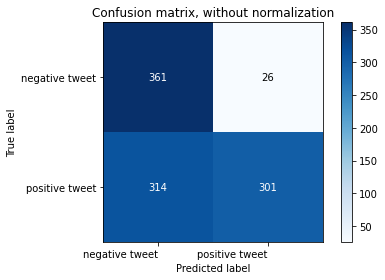

In [ ]:
plot_confusion_matrix(y_elect_test, pred_svm_tf,
                      classes=['negative tweet','positive tweet'])
plt.show()

**RESULTS:**

To evaluate the model more, both the F1 score and the Confusion Matrix have been used. With this, we can see from the confusion matrix that the model cannot predict the positive tweets well and labeled most of the tweets as negative as the model was trained on an imbalanced dataset. The only way to fix this would be to get more negative tweets and train the model again using a balanced dataset, or another way would be to try and duplicate the negative tweets and train the model on that to see how it performs.

**C) Visualize  the  sentiment prediction  results  and  the  true  sentiment  for  each  of  the  4  parties.**

In [ ]:
# Creating a column 'label' for all the four parties datafram with 0-negative and 1-positive
liberal_df['label'] = liberal_df['sentiment']
liberal_df['label'].replace('negative', 0, inplace=True)
liberal_df['label'].replace('positive', 1, inplace=True) 

conserv_df['label'] = conserv_df['sentiment']
conserv_df['label'].replace('negative', 0, inplace=True)
conserv_df['label'].replace('positive', 1, inplace=True) 

ndp_df['label'] = ndp_df['sentiment']
ndp_df['label'].replace('negative', 0, inplace=True)
ndp_df['label'].replace('positive', 1, inplace=True) 

ppc_df['label'] = ppc_df['sentiment']
ppc_df['label'].replace('negative', 0, inplace=True)
ppc_df['label'].replace('positive', 1, inplace=True) 

In [ ]:
# Splitting the dataframe into x-features and y-labels for the four parties
x_lib = liberal_df['text']
y_lib = liberal_df['label']

x_con = conserv_df['text']
y_con = conserv_df['label']

x_ndp = ndp_df['text']
y_ndp = ndp_df['label']

x_ppc = ppc_df['text']
y_ppc = ppc_df['label']

In [ ]:
# Applying TF-IDF on all the 4 parties features
tf_x_lib = tfvector.transform(x_lib)
tf_x_con = tfvector.transform(x_con)
tf_x_ndp = tfvector.transform(x_ndp)
tf_x_ppc = tfvector.transform(x_ppc)

In [ ]:
# SVM TF-IDF TESTING ON EACH PARTY
# LIBERAL PARTY 
pred_svm_tf_lib = svm_tf.predict(tf_x_lib)
print('The Accuracy FOR LIBERAL PARTY', accuracy_score(y_lib,pred_svm_tf_lib))

# CONSERVATIVE PARTY
pred_svm_tf_con = svm_tf.predict(tf_x_con)
print('The Accuracy FOR CONSERVATIVE PARTY', accuracy_score(y_con,pred_svm_tf_con))


# NDP PARTY
pred_svm_tf_ndp = svm_tf.predict(tf_x_ndp)
print('The Accuracy FOR NDP PARTY', accuracy_score(y_ndp,pred_svm_tf_ndp))


# PPC PARTY
pred_svm_tf_ppc = svm_tf.predict(tf_x_ppc)
print('The Accuracy FOR PPC PARTY', accuracy_score(y_ppc,pred_svm_tf_ppc))



The Accuracy FOR LIBERAL PARTY 0.6231343283582089
The Accuracy FOR CONSERVATIVE PARTY 0.6491228070175439
The Accuracy FOR NDP PARTY 0.5833333333333334
The Accuracy FOR PPC PARTY 0.4166666666666667


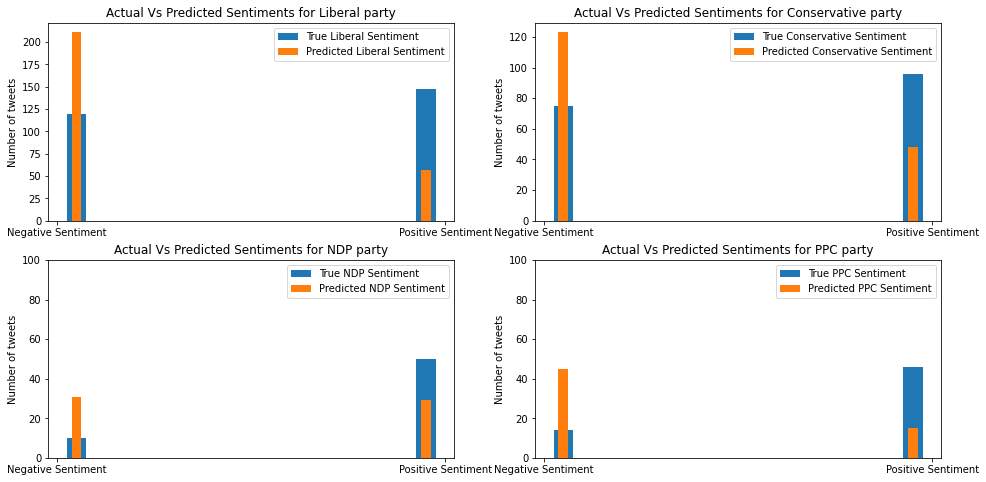

In [ ]:
# Plotting the Actual and predicted training values
party_sent = ['Negative Sentiment', 'Positive Sentiment']
plt.figure(figsize=(16,8))

#Plotting the LIBERAL party sentiment prediction
plt.subplot(2,2,1)
plt.hist(y_lib,label='True Liberal Sentiment',rwidth=0.5)
plt.hist(pred_svm_tf_lib,label='Predicted Liberal Sentiment',rwidth=0.25)
plt.legend()
plt.xticks(np.arange(2), party_sent)
plt.ylabel('Number of tweets')   
plt.title('Actual Vs Predicted Sentiments for Liberal party')



#Plotting the CONSERVATIVE party sentiment prediction
plt.subplot(2,2,2)
plt.hist(y_con,label='True Conservative Sentiment',rwidth=0.5)
plt.hist(pred_svm_tf_con,label='Predicted Conservative Sentiment',rwidth=0.25)
plt.legend()
plt.xticks(np.arange(2), party_sent)
plt.ylabel('Number of tweets')   
plt.title('Actual Vs Predicted Sentiments for Conservative party')


#Plotting the NDP party sentiment prediction
plt.subplot(2,2,3)
plt.hist(y_ndp,label='True NDP Sentiment',rwidth=0.5)
plt.hist(pred_svm_tf_ndp,label='Predicted NDP Sentiment',rwidth=0.25)
plt.legend()
plt.xticks(np.arange(2), party_sent)
plt.ylabel('Number of tweets')   
plt.title('Actual Vs Predicted Sentiments for NDP party')
plt.ylim(0,100)

#Plotting the PPC party sentiment prediction
plt.subplot(2,2,4)
plt.hist(y_ppc,label='True PPC Sentiment',rwidth=0.5)
plt.hist(pred_svm_tf_ppc,label='Predicted PPC Sentiment',rwidth=0.25)
plt.xticks(np.arange(2), party_sent)
plt.title('Actual Vs Predicted Sentiments for PPC party')
plt.ylabel('Number of tweets')   
plt.legend()
plt.ylim(0,100)
plt.show()

**RESULTS:**

From the bar chart, our model, as discussed earlier, predicts most of the tweets as negative due to the imbalanced dataset it was trained on, and it is the case here as well. The way to improve it was also mentioned before, and those methods would make a difference in getting a much more accurate result.

The above bar chart shows that both liberal and conservative parties, being the most popular parties in Canada, have the most amount of tweets associated with them. So they have the most positive as well as the most negative tweets. Both the liberal and the conservative parties have an almost equal split between the number of positive and negative tweets. So it is not advisable to rely solely on this data to say who will win this election definitively; it could go both ways. 

In [ ]:
# Creating a dataframe of only negative tweets for the election dataset
df_elect_neg = df_elect_cl.copy()
df_elect_neg.drop(index=df_elect_neg[df_elect_neg['sentiment'] == 'positive'].index,inplace=True)

In [ ]:
# Label encoding the negative reasons to predict it using the best model SVM using TF-IDF 
neg_reason_encode = {
    'others': 0,
    'calling election early': 1,
    'tell lies': 2,
    'economy': 4,
    'gun control': 5,
    'covid': 3,
    'climate problem': 6,
    'scandal': 7,
    'healthcare and marijuana': 8,
    'women reproductive right and racism': 9,
    'segregation': 10}
# Mapping the labels to the negative reasons 
df_elect_neg['negative_reason'] = df_elect_neg['negative_reason'].map(neg_reason_encode)
# For some reason the covid reason alone didn't change to 3 and became nan, so replacing all nan with 3
df_elect_neg['negative_reason'] = df_elect_neg['negative_reason'].replace(np.nan,3)
# Displaying the election dataset
df_elect_neg


,text,sentiment,negative_reason,label
0,"canadian election power grab pm trudeau , yes ...",negative,1.0,0
1,hope trudeau loses canadian election tomorrow ...,negative,3.0,0
3,canadian friends : never forget trudeau 2 year...,negative,1.0,0
5,vaccines guns key election o'toole serious pla...,negative,3.0,0
6,"im sorry , moderators respond leadership candi...",negative,0.0,0
...,...,...,...,...
997,absolutely horrible canada . forthcoming elect...,negative,0.0,0
998,@ davidakin trudeau imposes gun control polici...,negative,5.0,0
999,canada election stolen thugs . uneducated goon...,negative,0.0,0
1000,"o'toole amends platform gun control , question...",negative,2.0,0


In [ ]:
# Splitting the negative election dataset into 70% training and 30% testing set
x_train_neg,x_test_neg,y_train_neg,y_test_neg = train_test_split(df_elect_neg['text'],df_elect_neg['negative_reason'],test_size=0.3,random_state=0)

In [ ]:
# Applying TF-IDF 
tfvector = TfidfVectorizer()
tf_x_train_neg = tfvector.fit_transform(x_train_neg)
tf_x_test_neg = tfvector.transform(x_test_neg)

In [ ]:
# Chose the best model for prediction
# Hyperparameter tuning is done by passing 5-C values and the best value is selected based on the f1 score
svm_c = np.arange(0.1,1,0.2)
f1_scores_svm = []
for c in svm_c:
  print(c)
  svm_tf = LinearSVC(C=c)
  svm_tf.fit(tf_x_train_neg, y_train_neg)
  pred_svm_tf = svm_tf.predict(tf_x_test_neg)
  f1 = f1_score(y_test_neg,pred_svm_tf,average='weighted')
  f1_scores_svm.append(f1)

best_c_value = svm_c[f1_scores_svm.index(max(f1_scores_svm))]
print('The best F1 Score is:',max(f1_scores_svm), 'for c value:', best_c_value)

0.1
0.30000000000000004
0.5000000000000001
0.7000000000000001
0.9000000000000001
The best F1 Score is: 0.4609316827605913 for c value: 0.9000000000000001


In [ ]:
# Calculating all the performance metrics using the best c-value
svm_tf = LinearSVC(C=best_c_value)
svm_tf.fit(tf_x_train_neg, y_train_neg)
pred_svm_tf = svm_tf.predict(tf_x_test_neg)
print(classification_report(y_test_neg, pred_svm_tf))

              precision    recall  f1-score   support

         0.0       0.62      0.73      0.67        52
         1.0       0.48      0.87      0.62        15
         2.0       0.14      0.21      0.17        14
         3.0       0.50      0.14      0.22         7
         4.0       0.00      0.00      0.00         9
         5.0       0.80      0.80      0.80         5
         6.0       1.00      0.17      0.29         6
         7.0       0.00      0.00      0.00         5
         8.0       0.00      0.00      0.00         2
         9.0       0.00      0.00      0.00         2

    accuracy                           0.51       117
   macro avg       0.35      0.29      0.28       117
weighted avg       0.47      0.51      0.46       117



**RESULTS:**

Here the model did poorly and only got 51% accuracy. The main reason behind this is that the model was only trained on 271 samples and the dataset also had 11 classes. The number of samples for each of these classes was also not balanced; some had way more than the others. So the model couldn't do well on the testing set. Also, the test set didn't have all the classes; as we can see from the classification report, it missed one of the classes. This happened because the class most likely had very few samples, and the test size was also small (116).

**b. Suggest one way you can improve the accuracy of your selected model.**


The best way to improve this is by reducing the number of classes from 11 to maybe 2 or 3, which could improve the model's overall performance by maybe 10-15%. The other method would be to get more samples for all the classes, which would lead to a much better model with accuracy and f1 score in the high 80s or even 90s.

c) Use the frequency of the words (Bag of Words) for (i) positive and (ii) negative 
tweets using the ground truth sentiment to rank the top-50 most frequent non-stop-
words in the Canadian elections dataset. Use the true sentiment labels in the 
Canadian elections data. 

In [ ]:
# Creating a dataframe of only negative tweets for the election dataset
df_elect_neg = df_elect_cl.copy()
df_elect_pos = df_elect_cl.copy()
df_elect_neg.drop(index=df_elect_neg[df_elect_neg['sentiment'] == 'positive'].index,inplace=True)
df_elect_pos.drop(index=df_elect_pos[df_elect_pos['sentiment'] == 'negative'].index,inplace=True)

In [ ]:
# Applying Bag of Words on the election dataset
vector = CountVectorizer()
vector1 = CountVectorizer()
bow_df_elect_neg = vector.fit_transform(df_elect_neg['text'])
vocab = vector.get_feature_names() # getting the feature names to find the 50 most frequent words
bow_df_elect_pos = vector1.fit_transform(df_elect_pos['text'])
vocab_pos = vector1.get_feature_names() # getting the feature names to find the 50 most frequent words

In [ ]:
# Converting the positive and negative tweet words into dataframe
elec_neg = pd.DataFrame(bow_df_elect_neg.todense(),columns=vocab)
elec_pos = pd.DataFrame(bow_df_elect_pos.todense(),columns=vocab_pos)

In [ ]:
# Summing up the words for the negative set 
sum_of_neg = elec_neg.sum()
top_50_neg = sum_of_neg.sort_values(ascending=False)[:50] # Taking only the 50 most used words
top_50_neg = pd.DataFrame(top_50_neg,columns=['Frequency']) 
top_50_neg

,Frequency
election,265
trudeau,156
canadians,147
otoole,98
canada,77
canadian,64
pandemic,51
justintrudeau,47
elxn44,45
like,43


In [ ]:
 # Summing up the words for the positive set 
sum_of_pos = elec_pos.sum()
top_50_pos = sum_of_pos.sort_values(ascending=False)[:50] # Taking only the 50 most used words
top_50_pos = pd.DataFrame(top_50_pos,columns=['Frequency'])
top_50_pos

,Frequency
election,399
vote,190
canadian,177
trudeau,176
canadians,141
otoole,135
canada,126
good,74
elxn44,71
win,62


**Results:**
From the above findings, we can see that for: 

1) **Top 50 Words in the Negative tweets:**  

The most commonly used are 'trudeau', 'otoole', and the 'pandemic' from this, we can see most of the negative tweets are aimed at Trudeau, with 156 negative tweets compared to otoole with 98. This would imply that the Canadian people are not favoring Justin Trudeau, and they might vote him out.

2) **Top 50 Words in the Positive tweets:**

The most commonly used words are 'trudeau', 'otoole', and 'good'; this is again very similar to the negative set, but here Trudeau has 176 positive tweets whereas otoole has 136. This shows that both Justin Trudeau and Erin otoole have a good amount of positive and negative tweets. The fact that Justin Trudeau won the previous election tells us that it is not easy to predict election results just by using Twitter tweets, as the majority of Canadians may not even be on Twitter voicing their opinions on politics.